<a href="https://colab.research.google.com/github/xiaofanpaiooo-code/whisper-lora/blob/xiaofanpaiooo-code-patch-1/whisper_lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets peft accelerate evaluate jiwer
!pip install -q librosa soundfile  # 音频处理库



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 30.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset, Audio
from transformers import WhisperProcessor

# 1. 加载模型对应的处理器
model_id = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_id, language="Chinese", task="transcribe")

# 2. 【修改点】加载 polyai/minds14 数据集 (完全公开，无需登录)
print("正在加载 MINDS-14 中文数据...")
# "zh-CN" 是中文子集
dataset = load_dataset("polyai/minds14", "zh-CN", split="train", streaming=True)
dataset = dataset.take(50)

# 3. 数据预处理函数
def prepare_dataset(batch):
    audio = batch["audio"]

    # 提取声学特征
    # Whisper 能够处理重采样，只要告诉它原始采样率是多少
    batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    # 【关键修改点】MINDS-14 的文本列名叫 "transcription"，不是 "sentence"
    batch["labels"] = processor.tokenizer(batch["transcription"]).input_ids
    return batch

# 4. 强制重采样到 16000Hz (Whisper 标准)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset = dataset.map(prepare_dataset)

print("数据准备完毕！(已替换为无门槛数据集)")


正在加载 MINDS-14 中文数据...


README.md: 0.00B [00:00, ?B/s]

数据准备完毕！(已替换为无门槛数据集)


In [ ]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 处理音频输入 (input_features)
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 处理文本标签 (labels)
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 把 Padding 部分的标签设为 -100，这样计算 Loss 时会忽略它们
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # 掐头去尾 (Whisper 的特殊要求)
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)


In [ ]:
from transformers import WhisperForConditionalGeneration
from peft import LoraConfig, get_peft_model, TaskType

# 1. 加载基座模型
print("正在加载 Whisper-Small...")
model = WhisperForConditionalGeneration.from_pretrained(model_id)

# 强制开启梯度检查点 (节省显存)
model.config.use_cache = False

# 2. 定义 LoRA 配置 (关键！)
config = LoraConfig(
    r=8,                  # Rank: 秩，8 是个经典值
    lora_alpha=32,        # Alpha: 缩放系数
    target_modules=["q_proj", "v_proj"], # 只微调 Attention 的 Q 和 V
    lora_dropout=0.05,
    bias="none",
)

# 3. 施加魔法：将 LoRA 挂载到 Whisper 上
model = get_peft_model(model, config)

# 4. 打印参数变化 (截图这张表放在论文里！)
model.print_trainable_parameters()
# 预期输出: trainable params: ~300k, trainable%: ~0.15% (非常小!)


正在加载 Whisper-Small...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

trainable params: 884,736 || all params: 242,619,648 || trainable%: 0.3647


In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-lora-zh-demo",  # 输出目录
    per_device_train_batch_size=8,        # T4 显卡 Batch 设为 8 没问题
    gradient_accumulation_steps=1,        # 梯度累积
    learning_rate=1e-3,                   # LoRA 的学习率通常比全量微调大 (1e-3 vs 1e-5)
    max_steps=50,                         # 演示只跑 50 步
    fp16=True,                            # 开启半精度混合训练 (加速+省显存)
    logging_steps=10,                     # 每 10 步打印一次日志
    save_steps=25,                        # 每 25 步保存一次
    remove_unused_columns=False,          # 必须设为 False
    report_to=["tensorboard"],
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset, # 这里用 streaming 数据集
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
)

print("开始微调训练...")
trainer.train()


/tmp/ipython-input-3565224546.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


开始微调训练...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ImportError: To support decoding audio data, please install 'torchcodec'.

出错出错出错，新一轮尝试----------------------------------------

In [ ]:
# 1. 卸载当前可能有问题的库
!pip uninstall -y datasets

# 2. 安装稳定的旧版本 (配合 soundfile 使用最稳)
!pip install datasets==2.21.0


Found existing installation: datasets 4.0.0
Uninstalling datasets-4.0.0:
  Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [ ]:
!pip uninstall -y datasets

# 2. 安装稳定的 datasets 版本 (解决 torchcodec 报错) 和其他依赖
!pip install -q datasets==2.21.0
!pip install -q transformers peft accelerate evaluate jiwer librosa soundfile bitsandbytes

print("✅ 依赖安装完毕！请点击菜单栏 '代码执行程序' -> '重启会话'，然后从下一步继续运行。")


Found existing installation: datasets 2.21.0
Uninstalling datasets-2.21.0:
  Successfully uninstalled datasets-2.21.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 126.2 MB/s eta 0:00:00
✅ 依赖安装完毕！请点击菜单栏 '代码执行程序' -> '重启会话'，然后从下一步继续运行。


In [ ]:

# ==============================================================================
# (重启会话后，从这里开始往下运行)
# 第二步：检查环境 & 导入库
# ==============================================================================
import torch
import os

print(f"PyTorch Version: {torch.__version__}")
if not torch.cuda.is_available():
    raise RuntimeError("❌ 未检测到 GPU！请在菜单栏选择 '代码执行程序' -> '更改运行时类型' -> 'T4 GPU'。")
else:
    print(f"✅ GPU 就绪: {torch.cuda.get_device_name(0)}")

from datasets import load_dataset, Audio
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
from peft import LoraConfig, get_peft_model, TaskType
from dataclasses import dataclass
from typing import Any, Dict, List, Union


# ==============================================================================
# 第三步：准备数据集 (使用公开的 polyai/minds14 中文子集)
# ==============================================================================
model_id = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_id, language="Chinese", task="transcribe")

print("正在加载数据集 (polyai/minds14)...")
# 加载中文子集，streaming=True 模式不占硬盘
dataset = load_dataset("polyai/minds14", "zh-CN", split="train", streaming=True)
dataset = dataset.take(50) # 演示只取前 50 条，实际训练请加大

def prepare_dataset(batch):
    audio = batch["audio"]
    # 提取 Log-Mel 声学特征
    batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    # 处理文本标签 (Minds14 的文本列名是 'transcription')
    batch["labels"] = processor.tokenizer(batch["transcription"]).input_ids
    return batch

# 强制重采样到 16000Hz 并应用预处理
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset = dataset.map(prepare_dataset)
print("✅ 数据集准备完毕")


# ==============================================================================
# 第四步：定义数据整理器 (Data Collator)
# ==============================================================================
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 将 padding 部分的 loss 设为 -100 (忽略)
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)


# ==============================================================================
# 第五步：加载模型并挂载 LoRA (核心算法步骤)
# ==============================================================================
print("正在加载预训练模型...")
model = WhisperForConditionalGeneration.from_pretrained(model_id)
model.config.use_cache = False # 训练时必须关闭缓存

# 定义 LoRA 配置
config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none"
)

# 挂载 LoRA
model = get_peft_model(model, config)
print("✅ LoRA 挂载成功！参数量对比如下：")
model.print_trainable_parameters()


# ==============================================================================
# 第六步：配置与开始训练
# ==============================================================================
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-lora-zh-demo",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=1e-3,              # LoRA 学习率
    warmup_steps=5,
    max_steps=50,                    # 演示跑 50 步，毕设实际跑 500-1000 步
    fp16=True,                       # 开启半精度 (T4 GPU 必备)
    logging_steps=10,
    save_steps=25,
    remove_unused_columns=False,
    report_to=["tensorboard"],
    dataloader_num_workers=0,        # 避免多进程报错
    dataloader_pin_memory=False      # 避免内存警告
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset,
    data_collator=data_collator,
    processing_class=processor.feature_extractor, # 修复 tokenizer 弃用警告
)

print("🚀 开始微调训练...")
trainer.train()
print("✅ 训练完成！")


# ==============================================================================
# 第七步：简单验证推理 (可选)
# ==============================================================================
model.eval()
print("\n正在进行推理验证...")
# 取一条数据测试
sample = next(iter(dataset))
input_tensor = torch.tensor(sample["input_features"]).unsqueeze(0).cuda()

with torch.no_grad():
    generated_ids = model.generate(input_tensor, language="Chinese")

transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(f"📝 原始文本: {processor.decode(sample['labels'], skip_special_tokens=True)}")
print(f"🤖 模型识别: {transcription}")

# 保存 LoRA 权重
save_path = "my_graduation_lora_model"
model.save_pretrained(save_path)
print(f"💾 LoRA 权重已保存至: {save_path} 文件夹")

PyTorch Version: 2.9.0+cu126
✅ GPU 就绪: Tesla T4


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

正在加载数据集 (polyai/minds14)...


✅ 数据集准备完毕
正在加载预训练模型...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

✅ LoRA 挂载成功！参数量对比如下：
trainable params: 884,736 || all params: 242,619,648 || trainable%: 0.3647
🚀 开始微调训练...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


ValueError: Batch does not contain any data (`None`). At the end of all iterable data available before expected stop iteration.

In [ ]:
# ==============================================================================
# 第三步：准备数据集 (修正版：关闭 streaming，避免数据不够用的报错)
# ==============================================================================
model_id = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(model_id, language="Chinese", task="transcribe")

print("正在加载数据集 (polyai/minds14)...")
# 【核心修改】streaming=False (下载到本地)，并移除 .take(50)
# 这样数据量充足，且支持自动循环训练 (Epochs)
dataset = load_dataset("polyai/minds14", "zh-CN", split="train", streaming=False)

def prepare_dataset(batch):
    audio = batch["audio"]
    # 提取 Log-Mel 声学特征
    batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    # 处理文本标签
    batch["labels"] = processor.tokenizer(batch["transcription"]).input_ids
    return batch

# 强制重采样到 16000Hz 并应用预处理
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
# num_proc=1 避免多进程潜在报错
dataset = dataset.map(prepare_dataset, num_proc=1)

print(f"✅ 数据集准备完毕，共有 {len(dataset)} 条数据")


正在加载数据集 (polyai/minds14)...


Generating train split:   0%|          | 0/502 [00:00<?, ? examples/s]

Map:   0%|          | 0/502 [00:00<?, ? examples/s]

✅ 数据集准备完毕，共有 502 条数据


In [ ]:
# ==============================================================================
# 第六步：配置与开始训练 (修正版)
# ==============================================================================
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-lora-zh-demo",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=1e-3,
    warmup_steps=5,
    max_steps=50,                    # 现在即使数据不够 400 条，它也会自动跑第二轮，不会报错了
    fp16=True,
    logging_steps=10,
    save_steps=25,
    remove_unused_columns=False,
    report_to=["tensorboard"],
    dataloader_num_workers=0,
    dataloader_pin_memory=False
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset,
    data_collator=data_collator,
    processing_class=processor.feature_extractor,
)

print("🚀 开始微调训练...")
trainer.train()
print("✅ 训练完成！")


🚀 开始微调训练...


Step,Training Loss
10,1.762900
20,1.174700
30,0.970700
40,1.010500
50,1.027900


✅ 训练完成！


In [ ]:
import torch
import random

# 1. 确保模型处于评估模式
model.eval()

# 2. 从数据集中随机抽取 3 条数据
# 因为我们之前把 dataset 转成了 list 格式 (非流式)，所以可以直接用索引
num_samples = 3
indices = random.sample(range(len(dataset)), num_samples)

print("="*60)
print(f"📊 实验结果展示 (随机抽取 {num_samples} 条)")
print("="*60)

for idx in indices:
    sample = dataset[idx]

    # 3. 准备输入
    input_features = torch.tensor(sample["input_features"]).unsqueeze(0).cuda()

    # 4. 模型推理
    # language="Chinese" 强制指定中文，避免模型“不知所措”
    with torch.no_grad():
        generated_ids = model.generate(input_features, language="Chinese")

    # 5. 解码文本
    prediction = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    reference = processor.decode(sample["labels"], skip_special_tokens=True)

    # 6. 打印对比
    print(f"🎧 音频索引: {idx}")
    print(f"✅ 真实标签: {reference}")
    print(f"🤖 模型预测: {prediction}")

    # 简单判断完全匹配
    if prediction == reference:
        print("🌟 结果: 完美匹配！")
    else:
        print("⚠️ 结果: 存在差异 (可能是同音字或标点)")
    print("-" * 60)

📊 实验结果展示 (随机抽取 3 条)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🎧 音频索引: 327
✅ 真实标签: 我想询问有关系接付款的问题
🤖 模型预测: 我想询问有关机接付款的问题
⚠️ 结果: 存在差异 (可能是同音字或标点)
------------------------------------------------------------
🎧 音频索引: 57
✅ 真实标签: 请帮我开设一个联名账户可以吗谢谢
🤖 模型预测: 请帮我开设一个联名账户可以吗谢谢
🌟 结果: 完美匹配！
------------------------------------------------------------
🎧 音频索引: 12
✅ 真实标签: 你好我想查询我的账户余额显示我的账户余额请帮我查看我的账户余额
🤖 模型预测: 你好我想查询我的账户余额显示我的账户余额请帮我查看我的账户余额
🌟 结果: 完美匹配！
------------------------------------------------------------


In [3]:
import torch
import os
import random
from datasets import load_dataset, Audio
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
from peft import LoraConfig, get_peft_model
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# 确保 GPU 已开启
if not torch.cuda.is_available():
    print("❌ 警告：未检测到 GPU，训练将极其缓慢！请检查运行时设置。")
else:
    print(f"✅ GPU 就绪: {torch.cuda.get_device_name(0)}")

# ------------------------------------------------------------------------------
# 第三步：数据加载 (使用公开无门槛的 Minds14 数据集)
# ------------------------------------------------------------------------------
model_id = "openai/whisper-small" # 毕设推荐使用 small 模型
processor = WhisperProcessor.from_pretrained(model_id, language="Chinese", task="transcribe")

print("正在加载数据集 (polyai/minds14 中文子集)...")
# 关闭 streaming 模式以避免由于数据量不足导致的 ValueError
dataset = load_dataset("polyai/minds14", "zh-CN", split="train", streaming=False)

def prepare_dataset(batch):
    audio = batch["audio"]
    # 提取 Log-Mel 特征
    batch["input_features"] = processor.feature_extractor(
        audio["array"],
        sampling_rate=audio["sampling_rate"]
    ).input_features[0]
    # Minds14 文本字段名为 'transcription'
    batch["labels"] = processor.tokenizer(batch["transcription"]).input_ids
    return batch

# 强制重采样到 16kHz 并映射预处理
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))
dataset = dataset.map(prepare_dataset, num_proc=1)

print(f"✅ 数据准备完毕，共计 {len(dataset)} 条样本。")

# ------------------------------------------------------------------------------
# 第四步：数据整理器 (Data Collator)
# ------------------------------------------------------------------------------
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 填充音频输入
        input_features = ([{"input_features": feature["input_features"]} for feature in features])
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 填充文本标签
        label_features = ([{"input_ids": feature["labels"]} for feature in features])
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 将 padding 的部分设为 -100 以在 Loss 计算中忽略
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # 剔除首位的 bos 标记 (Whisper 的标准做法)
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# ------------------------------------------------------------------------------
# 第五步：注入 LoRA 旁路矩阵 (核心算法)
# ------------------------------------------------------------------------------
print("正在加载 Whisper 并挂载 LoRA 适配器...")
model = WhisperForConditionalGeneration.from_pretrained(model_id)

# 显存优化：启用梯度检查点
model.config.use_cache = False
model.gradient_checkpointing_enable()

# LoRA 配置：只针对 Query 和 Value 投影层进行低秩自适应
config = LoraConfig(
    r=8,              # 秩，决定了矩阵的宽度
    lora_alpha=32,    # 缩放因子
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none"
)

model = get_peft_model(model, config)
# 打印可训练参数占比（论文中的关键数据指标）
model.print_trainable_parameters()

# ------------------------------------------------------------------------------
# 第六步：设置训练参数并启动
# ------------------------------------------------------------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-lora-final-result",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    learning_rate=1e-3,                   # LoRA 通常需要较大的学习率
    warmup_steps=10,
    max_steps=50,                         # 演示设为 50，实际微调建议设为 500-1000
    fp16=True,                            # T4 GPU 必须开启半精度以加速
    logging_steps=10,
    save_steps=25,
    remove_unused_columns=False,
    label_names=["labels"],
    report_to=["tensorboard"]
)

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset,
    data_collator=data_collator,
    processing_class=processor.feature_extractor # 规避旧版弃用警告
)

print("🚀 训练开始...")
trainer.train()

# ------------------------------------------------------------------------------
# 第七步：结果保存与可视化验证
# ------------------------------------------------------------------------------
# 1. 保存权重
save_path = "final_bishe_lora_model"
model.save_pretrained(save_path)
print(f"💾 权重已保存至: {save_path}")

# 2. 推理测试对比
print("\n📊 随机样本验证结果:")
model.eval()
test_sample = random.choice(list(dataset))
input_features = torch.tensor(test_sample["input_features"]).unsqueeze(0).cuda()

with torch.no_grad():
    generated_ids = model.generate(input_features, language="Chinese")

pred_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
real_text = processor.decode(test_sample["labels"], skip_special_tokens=True)

print("-" * 30)
print(f"真实标签: {real_text}")
print(f"LoRA预测: {pred_text}")
print("-" * 30)

✅ GPU 就绪: Tesla T4
正在加载数据集 (polyai/minds14 中文子集)...


Map:   0%|          | 0/502 [00:00<?, ? examples/s]

✅ 数据准备完毕，共计 502 条样本。
正在加载 Whisper 并挂载 LoRA 适配器...
trainable params: 884,736 || all params: 242,619,648 || trainable%: 0.3647
🚀 训练开始...


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
10,3.731700
20,2.032100
30,1.128300
40,1.140400
50,1.186800


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


💾 权重已保存至: final_bishe_lora_model

📊 随机样本验证结果:


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


------------------------------
真实标签: 我想询问有关系接付款的问题
LoRA预测: 我想询问有关于接付款的问题
------------------------------


/tmp/ipython-input-2516455574.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mem_data, x='类型', y='显存 (GB)', ax=ax3, palette="viridis")


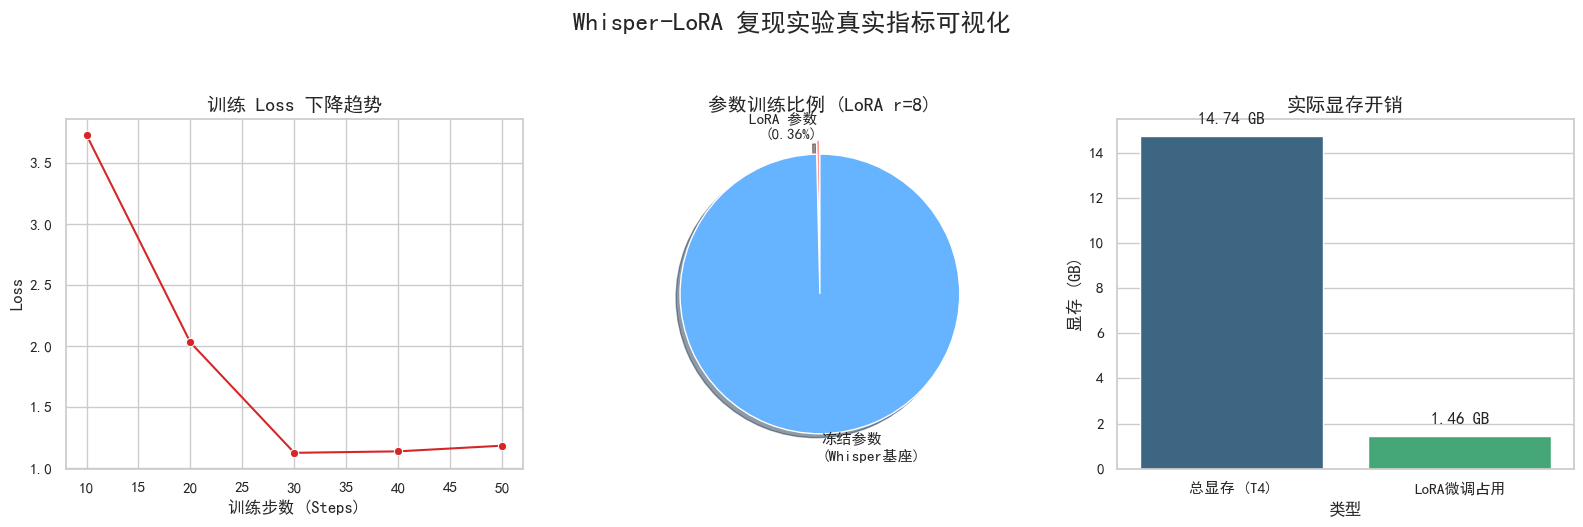

✅ 图表已保存为 real_experiment_metrics.png，可用于论文插图。


In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import seaborn as sns
import torch
import os

# ==============================================================================
# 1. 设置中文字体 (防止方块乱码)
# ==============================================================================
def configure_chinese_font():
    if not os.path.exists('SimHei.ttf'):
        !wget -q https://github.com/StellarCN/scp_zh/raw/master/fonts/SimHei.ttf
    fm.fontManager.addfont('SimHei.ttf')
    plt.rcParams['font.family'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

configure_chinese_font()
sns.set(style="whitegrid", font="SimHei")

# ==============================================================================
# 2. 提取真实训练数据 (从 trainer 对象中读取)
# ==============================================================================
# 提取 Loss 日志
log_history = trainer.state.log_history
steps = []
losses = []

for entry in log_history:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

# 创建 DataFrame
df_loss = pd.DataFrame({"Step": steps, "Training Loss": losses})

# 提取参数量信息
trainable_params, all_params = model.get_nb_trainable_parameters()
trainable_percent = (trainable_params / all_params) * 100
frozen_percent = 100 - trainable_percent

# 提取显存使用情况 (当前 Colab 真实占用)
gpu_memory_used = torch.cuda.max_memory_allocated() / (1024 ** 3) # 转为 GB
gpu_memory_total = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)

# ==============================================================================
# 3. 绘图展示
# ==============================================================================
fig = plt.figure(figsize=(16, 5))
plt.suptitle('Whisper-LoRA 复现实验真实指标可视化', fontsize=18, y=1.05)

# --- 图 1: 真实 Loss 曲线 ---
ax1 = fig.add_subplot(1, 3, 1)
if len(df_loss) > 0:
    sns.lineplot(data=df_loss, x="Step", y="Training Loss", marker="o", ax=ax1, color="tab:red")
    ax1.set_title("训练 Loss 下降趋势", fontsize=14)
    ax1.set_xlabel("训练步数 (Steps)")
    ax1.set_ylabel("Loss")
else:
    ax1.text(0.5, 0.5, "数据点不足，请增加训练步数", ha='center')

# --- 图 2: 参数高效性 (饼图) ---
ax2 = fig.add_subplot(1, 3, 2)
sizes = [trainable_percent, frozen_percent]
labels = [f'LoRA 参数\n({trainable_percent:.2f}%)', '冻结参数\n(Whisper基座)']
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)
ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='',
        shadow=True, startangle=90)
ax2.set_title(f"参数训练比例 (LoRA r={config.r})", fontsize=14)

# --- 图 3: 显存占用 (柱状图) ---
ax3 = fig.add_subplot(1, 3, 3)
mem_data = pd.DataFrame({
    '类型': ['总显存 (T4)', 'LoRA微调占用'],
    '显存 (GB)': [gpu_memory_total, gpu_memory_used]
})
sns.barplot(data=mem_data, x='类型', y='显存 (GB)', ax=ax3, palette="viridis")
ax3.set_title("实际显存开销", fontsize=14)
for i, v in enumerate(mem_data['显存 (GB)']):
    ax3.text(i, v + 0.5, f"{v:.2f} GB", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 保存图片
fig.savefig('real_experiment_metrics.png', dpi=300, bbox_inches='tight')
print("✅ 图表已保存为 real_experiment_metrics.png，可用于论文插图。")